Note that this notebook was run in an updated environment

In [1]:
# ==============================================================================
# 1. IMPORTS & PATCHES
# ==============================================================================
import sys
import numpy as np

# --- PATCH: Fix Numpy 1.24+ compatibility with older TensorFlow/Ray ---
if not hasattr(np, 'object'):
    np.object = object
if not hasattr(np, 'bool'):
    np.bool = bool
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'typeDict'):
    np.typeDict = np.sctypeDict

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import itertools
import random

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.utils.annotations import override

import or_gym
from or_gym.utils import create_env

# --- REPLACED: Import from dnamite instead of nodegam ---
from dnamite.models.base_single_split import _BaseSingleSplitDNAMiteModel

# ==============================================================================
# 2. CUSTOM MODEL WRAPPER FOR RLlib
# ==============================================================================

class LibraryDNAMite_RL(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        
        # Reduced dimension for simpler model
        self.contribution_dim = 16 
        n_features = obs_space.shape[0]
        
        # --- CONFIGURATION MATCHING DNAMiteRegressor DEFAULTS ---
        self.n_bins = 32  
        
        # Keep pairs conservative for now
        self.num_pairs = 10 
        
        # Determine bounds from observation space
        low = -100.0
        high = 100.0
        if hasattr(obs_space, 'low') and hasattr(obs_space, 'high'):
            if np.all(np.isfinite(obs_space.low)) and np.all(np.isfinite(obs_space.high)):
                l = np.min(obs_space.low)
                h = np.max(obs_space.high)
                if l > -1e6 and h < 1e6:
                    low = float(l)
                    high = float(h)
        
        print(f"DNAMite: Binning range [{low}, {high}], Bins={self.n_bins}")
        self.register_buffer('boundaries', torch.linspace(low, high, self.n_bins - 1))
        
        feature_sizes = [self.n_bins] * n_features
        
        # --- PAIR SELECTION LOGIC ---
        all_pairs = list(itertools.combinations(range(n_features), 2))
        
        if self.num_pairs is None or self.num_pairs >= len(all_pairs):
            selected_pairs = all_pairs
            print(f"DNAMite: Using ALL {len(selected_pairs)} interaction pairs.")
        else:
            random.seed(42) 
            selected_pairs = random.sample(all_pairs, self.num_pairs)
            print(f"DNAMite: Using {len(selected_pairs)} randomly selected interaction pairs (from {len(all_pairs)} possible).")

        # Create cat_feat_mask
        cat_feat_mask = torch.zeros(n_features, dtype=torch.bool)
        
        # Initialize DNAMite model (Underlying module of DNAMiteRegressor)
        self.node_model = _BaseSingleSplitDNAMiteModel(
            n_features=n_features,
            n_output=self.contribution_dim,
            feature_sizes=feature_sizes,
            n_embed=16,     # Reduced from 32
            n_hidden=16,    # Reduced from 32
            n_layers=2,     # Reduced from 2 (Shallower model)
            device='cpu',
            cat_feat_mask=cat_feat_mask,
            fit_pairs=True,           
            pairs_list=selected_pairs 
        )
        
        # --- STABILITY IMPROVEMENT ---
        # Add LayerNorm to stabilize outputs before the heads
        self.layer_norm = nn.LayerNorm(self.contribution_dim)
        
        self.actor_head = nn.Linear(self.contribution_dim, num_outputs)
        self.value_head = nn.Linear(self.contribution_dim, 1)
        self._last_total_contribution = None
        self._is_training = False

    def forward(self, input_dict, state, seq_lens):
        self._is_training = "is_training" not in input_dict or input_dict["is_training"]
        obs = input_dict["obs_flat"].float()
        
        # Discretize
        obs_indices = torch.bucketize(obs, self.boundaries)
        obs_indices = torch.clamp(obs_indices, 0, self.n_bins - 1)
        
        # Forward
        total_contribution = self.node_model(mains=obs_indices)
        
        # Apply LayerNorm for stability
        total_contribution = self.layer_norm(total_contribution)
        
        self._last_total_contribution = total_contribution
        logits = self.actor_head(total_contribution)
        return logits, state

    def value_function(self):
        assert self._last_total_contribution is not None
        value = self.value_head(self._last_total_contribution).squeeze(1)
        if not self._is_training:
            return value.cpu()
        return value

# Register the library-based model with RLlib
ModelCatalog.register_custom_model("library_dnamite", LibraryDNAMite_RL)

# ==============================================================================
# 3. ENVIRONMENT AND RLlib CONFIGURATION
# ==============================================================================

def register_env(env_name, env_config={}):
    env_creator = create_env(env_name)
    tune.register_env(env_name, lambda config: env_creator(env_name, env_config=config))

env_name = 'NetworkManagement-v0'

env_config = {}

rl_config = dict(
    env=env_name,
    num_workers=0,
    env_config=env_config,
    model=dict(
        custom_model="library_dnamite",
        custom_model_config={},
    ),
    clip_actions=True, 
    vf_clip_param=650000.0,
    lr=1.5e-5, # Further reduced LR for stability
    entropy_coeff=0.01,
    num_sgd_iter=20,
    train_batch_size=4000,
    sgd_minibatch_size=128,
    horizon=200, 
    framework="torch",
    num_gpus=0,
)

register_env(env_name, env_config)

# ==============================================================================
# 4. TRAINING AND ANALYSIS
# ==============================================================================

ray.init(ignore_reinit_error=True, num_gpus=0)

print("Initializing PPOTrainer with DNAMite model (Simpler configuration)...")
agent = PPOTrainer(env=env_name, config=rl_config)

results = []
print("Starting training...")
for i in range(300):
    res = agent.train()
    results.append(res)
    print(f"Iter: {i+1}\tReward: {res['episode_reward_mean']:.2f}")

print("\nTraining finished.")
checkpoint_path = agent.save()
print(f"\nAgent checkpoint saved at: {checkpoint_path}")

print("\nPlotting training rewards and losses...")
rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
mean_rewards = np.array([np.mean(rewards[i-100:i+1]) if i >= 100 else np.mean(rewards[:i+1]) for i, _ in enumerate(rewards)])
pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
# vf_loss = [i['info']['learner']['default_policy']['learner_stats']['vf_loss'] for i in results]

# fig, axes = plt.subplots(1, 3, figsize=(24, 6))
# axes[0].plot(mean_rewards, label='Mean Rewards')
# axes[0].set_title('Training Rewards')
# axes[0].set_xlabel('Episode Count (Approximation)')
# axes[0].set_ylabel('Reward')
# axes[0].grid(True)

# axes[1].plot(pol_loss)
# axes[1].set_title('Policy Loss')
# axes[1].set_xlabel('Iteration')
# axes[1].set_ylabel('Loss')
# axes[1].grid(True)

# axes[2].plot(vf_loss)
# axes[2].set_title('Value Function Loss')
# axes[2].set_xlabel('Iteration')
# axes[2].set_ylabel('Loss')
# axes[2].grid(True)

# plt.tight_layout()
# plt.show()

# print("\nTraining and results plotting complete.")
# print("DNAMite model successfully trained and visualized.")

# print("\nShutting down Ray...")
# ray.shutdown()

C:\Users\24912\AppData\Local\Temp\ipykernel_29528\1349930369.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):
C:\Users\24912\AppData\Local\Temp\ipykernel_29528\1349930369.py:10: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


Instructions for updating:
non-resource variables are not supported in the long term


2025-11-21 02:17:15,625	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2025-11-21 02:17:19,467	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2025-11-21 02:17:19,469	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2025-11-21 02:17:19,467	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2025-11-21 02:17:19,469	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Initializing PPOTrainer with DNAMite model (Simpler configuration)...
DNAMite: Binning range [-100.0, 100.0], Bins=32
DNAMite: Using 10 randomly selected interaction pairs (from 2278 possible).


2025-11-21 02:17:20,246	WARNING util.py:39 -- Install gputil for GPU system monitoring.


Starting training...
Iter: 1	Reward: -998.84
Iter: 1	Reward: -998.84
Iter: 2	Reward: -892.23
Iter: 2	Reward: -892.23
Iter: 3	Reward: -881.85
Iter: 3	Reward: -881.85
Iter: 4	Reward: -875.54
Iter: 4	Reward: -875.54
Iter: 5	Reward: -864.63
Iter: 5	Reward: -864.63
Iter: 6	Reward: -871.67
Iter: 6	Reward: -871.67
Iter: 7	Reward: -876.16
Iter: 7	Reward: -876.16
Iter: 8	Reward: -863.85
Iter: 8	Reward: -863.85
Iter: 9	Reward: -865.77
Iter: 9	Reward: -865.77
Iter: 10	Reward: -861.20
Iter: 10	Reward: -861.20
Iter: 11	Reward: -863.86
Iter: 11	Reward: -863.86
Iter: 12	Reward: -857.41
Iter: 12	Reward: -857.41
Iter: 13	Reward: -854.58
Iter: 13	Reward: -854.58
Iter: 14	Reward: -846.10
Iter: 14	Reward: -846.10
Iter: 15	Reward: -841.40
Iter: 15	Reward: -841.40
Iter: 16	Reward: -847.35
Iter: 16	Reward: -847.35
Iter: 17	Reward: -836.01
Iter: 17	Reward: -836.01
Iter: 18	Reward: -828.79
Iter: 18	Reward: -828.79
Iter: 19	Reward: -840.70
Iter: 19	Reward: -840.70
Iter: 20	Reward: -832.70
Iter: 20	Reward: -832.

Attempting to plot results from memory...
Found 300 iterations in 'results'.

--- Debugging Result Structure (First Iteration) ---
Learner keys: dict_keys(['default_policy'])
Policy stats keys: dict_keys(['allreduce_latency', 'cur_kl_coeff', 'cur_lr', 'total_loss', 'policy_loss', 'vf_loss', 'vf_explained_var', 'kl', 'entropy', 'entropy_coeff', 'model'])


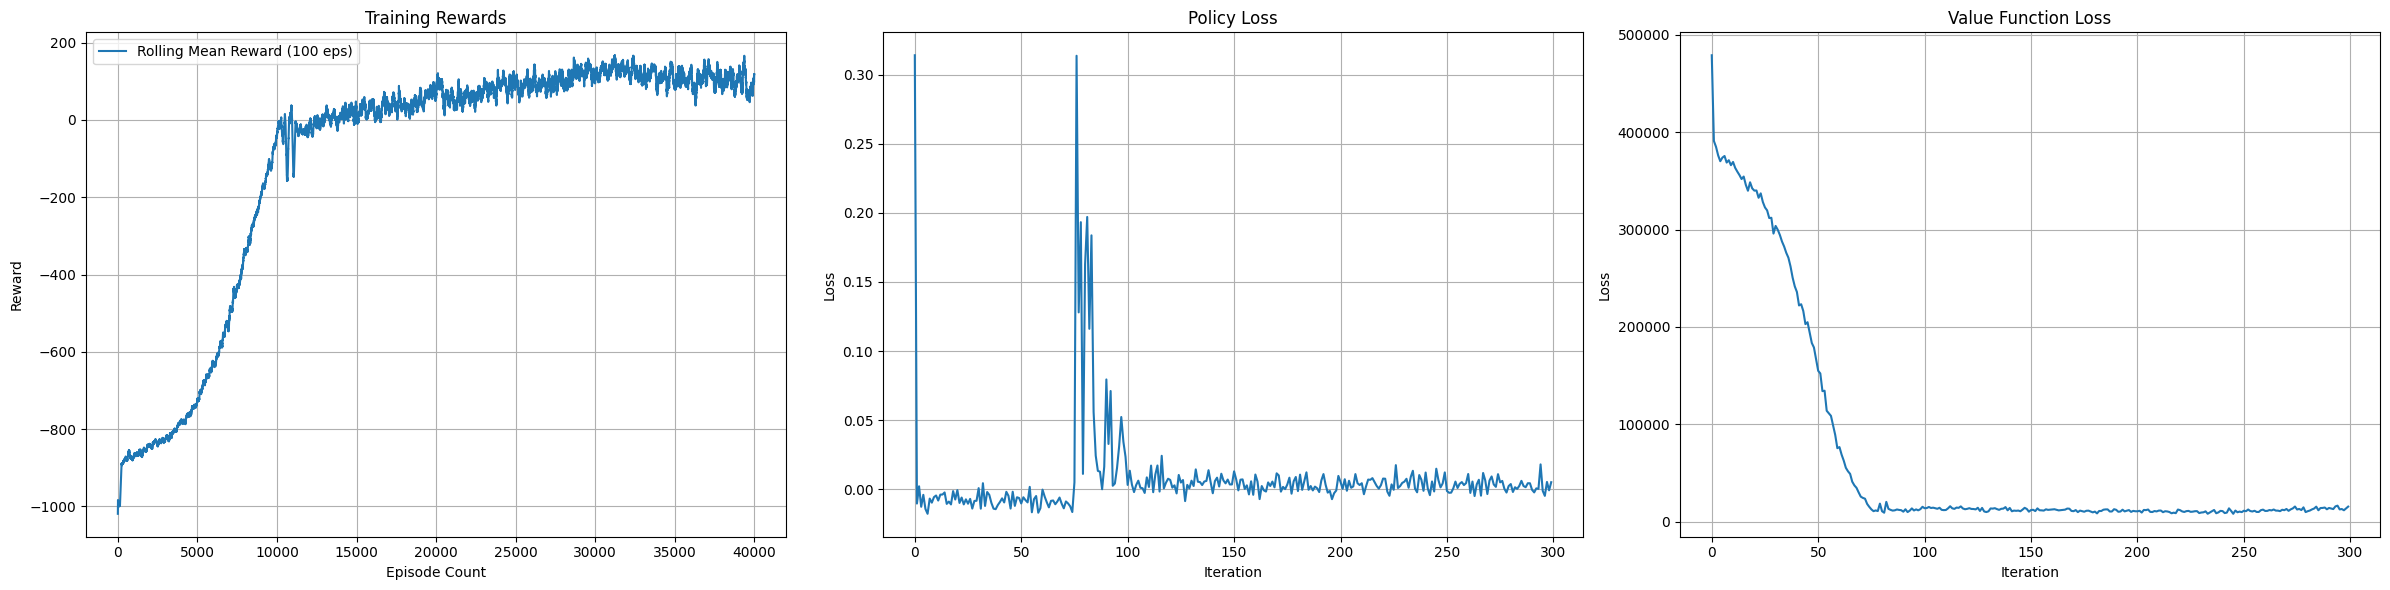


Training and results plotting complete.
DNAMite model successfully trained and visualized.

Shutting down Ray...


In [2]:
import matplotlib.pyplot as plt
import numpy as np

print("Attempting to plot results from memory...")

# Check if 'results' variable exists in the current session
if 'results' not in locals():
    print("Error: 'results' variable not found. Please ensure the training loop has run.")
else:
    print(f"Found {len(results)} iterations in 'results'.")
    
    # 1. Extract Rewards safely
    all_rewards = []
    for i, res in enumerate(results):
        # Check if hist_stats and episode_reward exist
        if 'hist_stats' in res and 'episode_reward' in res['hist_stats']:
            ep_rewards = res['hist_stats']['episode_reward']
            if len(ep_rewards) > 0:
                all_rewards.extend(ep_rewards)
    
    # 2. Extract Losses safely
    pol_loss = []
    vf_loss = []
    
    # --- DEBUG: Print structure of first result to find VF loss ---
    if len(results) > 0:
        print("\n--- Debugging Result Structure (First Iteration) ---")
        first_res = results[0]
        if 'info' in first_res and 'learner' in first_res['info']:
            learner_info = first_res['info']['learner']
            print("Learner keys:", learner_info.keys())
            if 'default_policy' in learner_info:
                policy_stats = learner_info['default_policy']
                print("Policy stats keys:", policy_stats.keys())
                if 'learner_stats' in policy_stats:
                    print("Learner stats keys:", policy_stats['learner_stats'].keys())
    # --------------------------------------------------------------

    for res in results:
        try:
            # Structure might vary, try to access safely
            # RLlib structure: info -> learner -> default_policy -> ...
            if 'info' in res and 'learner' in res['info'] and 'default_policy' in res['info']['learner']:
                policy_stats = res['info']['learner']['default_policy']
                
                # Policy Loss
                if 'policy_loss' in policy_stats:
                    pol_loss.append(policy_stats['policy_loss'])
                elif 'learner_stats' in policy_stats and 'policy_loss' in policy_stats['learner_stats']:
                     pol_loss.append(policy_stats['learner_stats']['policy_loss'])
                
                # VF Loss - Try multiple locations
                if 'vf_loss' in policy_stats:
                    vf_loss.append(policy_stats['vf_loss'])
                elif 'learner_stats' in policy_stats and 'vf_loss' in policy_stats['learner_stats']:
                    vf_loss.append(policy_stats['learner_stats']['vf_loss'])
                
        except Exception as e:
            pass

    # 3. Plotting
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Plot Rewards
    if len(all_rewards) > 0:
        rewards_np = np.array(all_rewards)
        # Calculate rolling mean (window=100)
        window = 100
        rolling_mean = []
        for i in range(len(rewards_np)):
            start = max(0, i - window + 1)
            rolling_mean.append(np.mean(rewards_np[start:i+1]))
        
        axes[0].plot(rolling_mean, label='Rolling Mean Reward (100 eps)')
        axes[0].set_title('Training Rewards')
        axes[0].set_xlabel('Episode Count')
        axes[0].set_ylabel('Reward')
        axes[0].grid(True)
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'No Reward Data', ha='center')
        axes[0].set_title('Training Rewards')

    # Plot Policy Loss
    if len(pol_loss) > 0:
        axes[1].plot(pol_loss)
        axes[1].set_title('Policy Loss')
        axes[1].set_xlabel('Iteration')
        axes[1].set_ylabel('Loss')
        axes[1].grid(True)
    else:
        axes[1].text(0.5, 0.5, 'No Policy Loss Data', ha='center')
        axes[1].set_title('Policy Loss')

    # Plot VF Loss
    if len(vf_loss) > 0:
        axes[2].plot(vf_loss)
        axes[2].set_title('Value Function Loss')
        axes[2].set_xlabel('Iteration')
        axes[2].set_ylabel('Loss')
        axes[2].grid(True)
    else:
        axes[2].text(0.5, 0.5, 'No VF Loss Data', ha='center')
        axes[2].set_title('Value Function Loss')

    plt.tight_layout()
    plt.show()
    print("\nTraining and results plotting complete.")
print("DNAMite model successfully trained and visualized.")

print("\nShutting down Ray...")
ray.shutdown()


--- Starting Feature Contribution Analysis ---


2025-11-21 23:54:30,082	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2025-11-21 23:54:33,241	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-21 23:54:33,252	INFO trainable.py:481 -- Restored on 192.168.2.24 from checkpoint: C:\Users\24912\ray_results\PPO_NetworkManagement-v0_2025-11-21_02-17-19ne93n4qj\checkpoint_300\checkpoint-300
2025-11-21 23:54:33,241	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-21 23:54:33,252	INFO trainable.py:481 -- Restored on 192.168.2.24 from checkpoint: C:\Users\24912\ray_results\PPO_NetworkManagement-v0_2025-11-21_02-17-19ne93n4qj\checkpoint_300\checkpoint-300
2025-11-21 23:54:33,254	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 25327.594254016876, '_episodes_total': 40000}
2025-11-21 23:54:33,254	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total

Feature Names: ['Market Demand 0', 'Inventory at Node 1', 'Inventory at Node 2', 'Inventory at Node 3', 'Inventory at Node 4', 'Inventory at Node 5', 'Inventory at Node 6', 'Pipeline State 0', 'Pipeline State 1', 'Pipeline State 2', 'Pipeline State 3', 'Pipeline State 4', 'Pipeline State 5', 'Pipeline State 6', 'Pipeline State 7', 'Pipeline State 8', 'Pipeline State 9', 'Pipeline State 10', 'Pipeline State 11', 'Pipeline State 12', 'Pipeline State 13', 'Pipeline State 14', 'Pipeline State 15', 'Pipeline State 16', 'Pipeline State 17', 'Pipeline State 18', 'Pipeline State 19', 'Pipeline State 20', 'Pipeline State 21', 'Pipeline State 22', 'Pipeline State 23', 'Pipeline State 24', 'Pipeline State 25', 'Pipeline State 26', 'Pipeline State 27', 'Pipeline State 28', 'Pipeline State 29', 'Pipeline State 30', 'Pipeline State 31', 'Pipeline State 32', 'Pipeline State 33', 'Pipeline State 34', 'Pipeline State 35', 'Pipeline State 36', 'Pipeline State 37', 'Pipeline State 38', 'Pipeline State 39

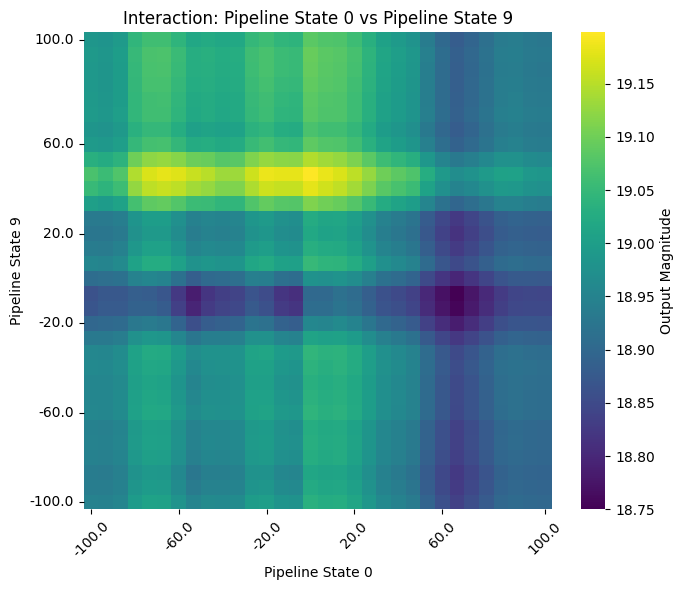

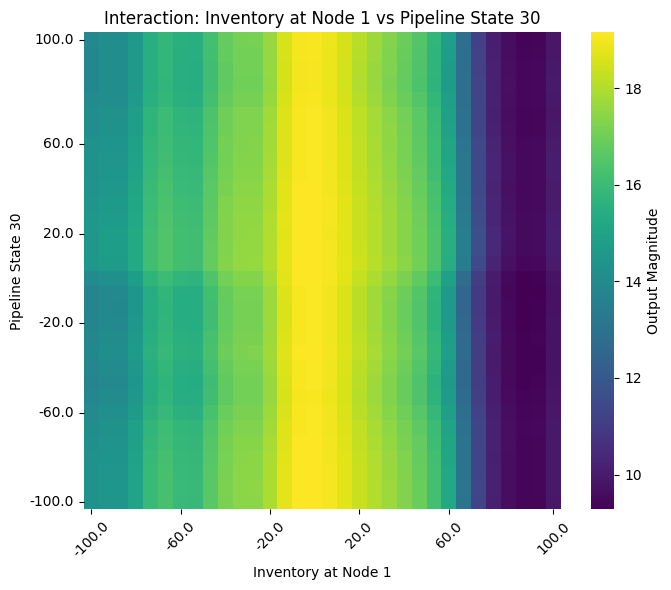

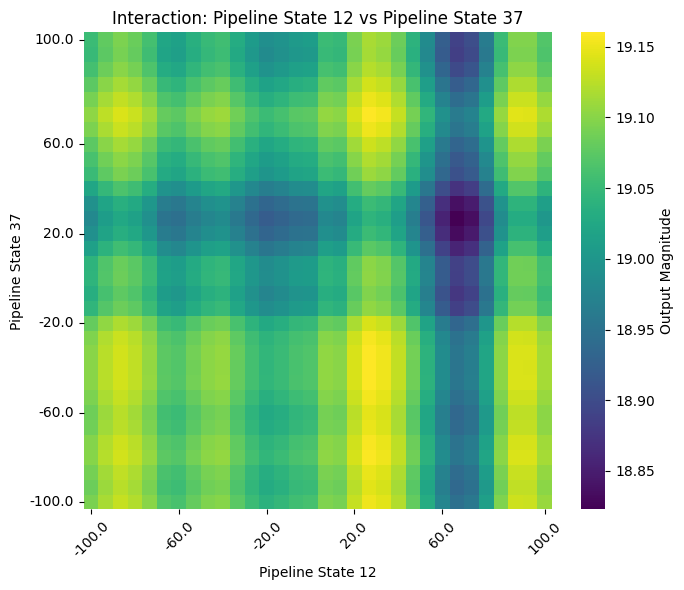

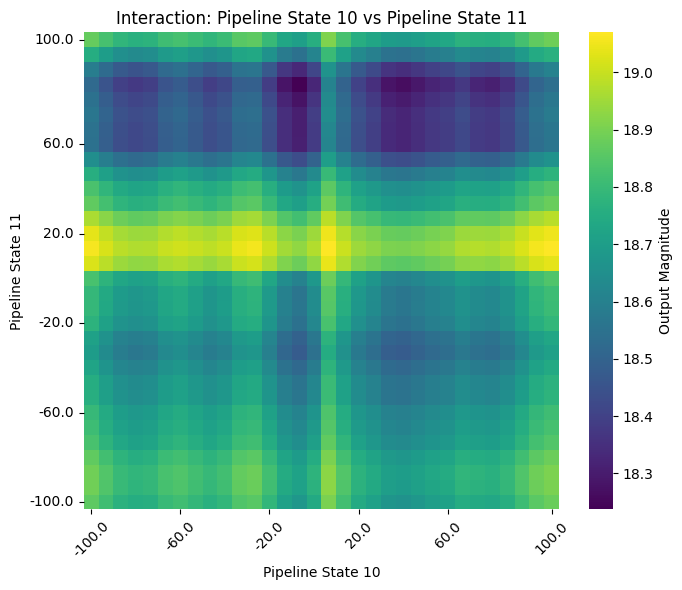

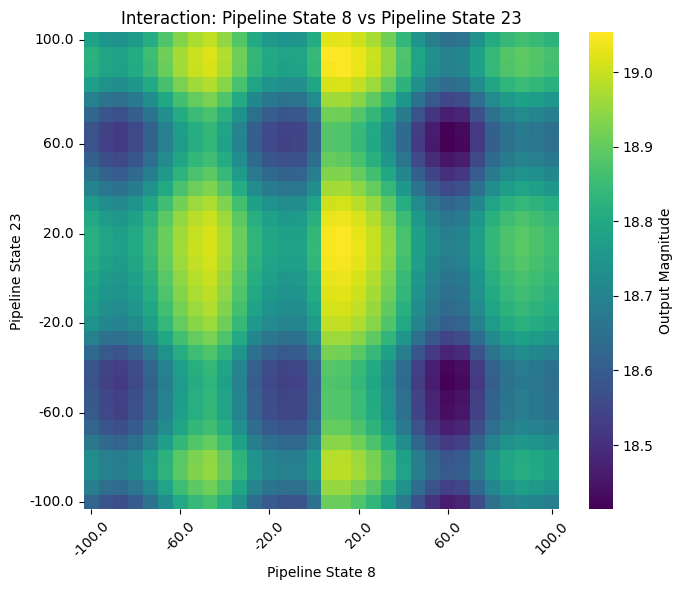

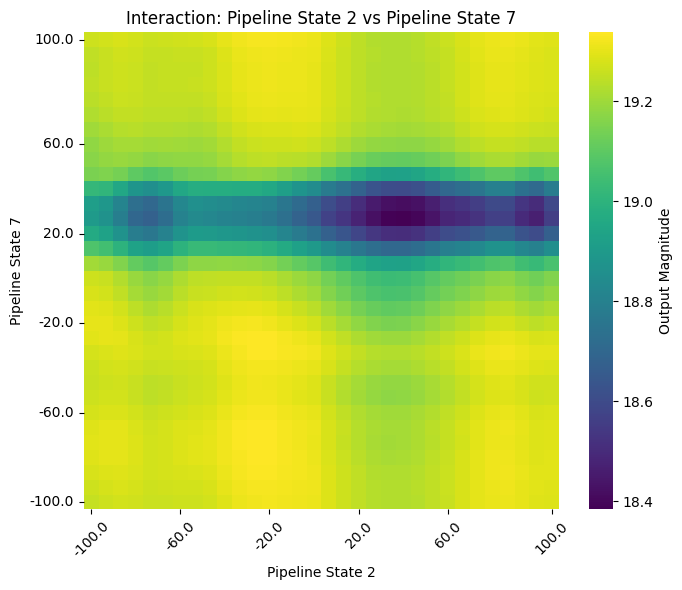

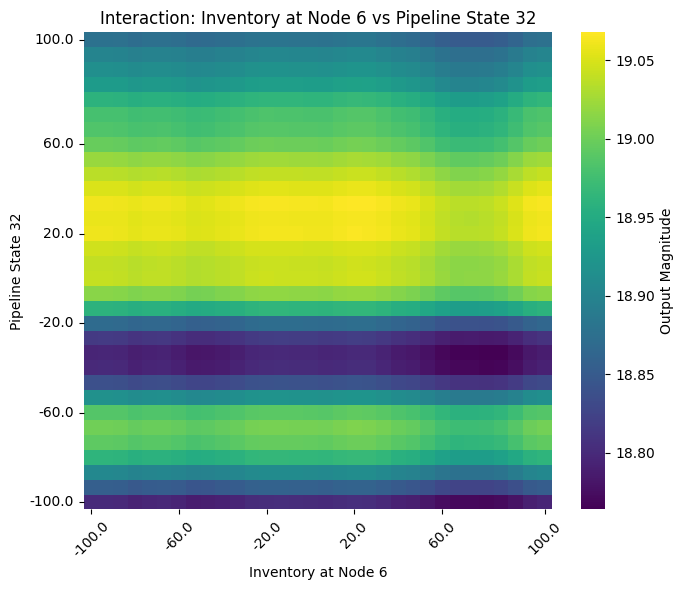

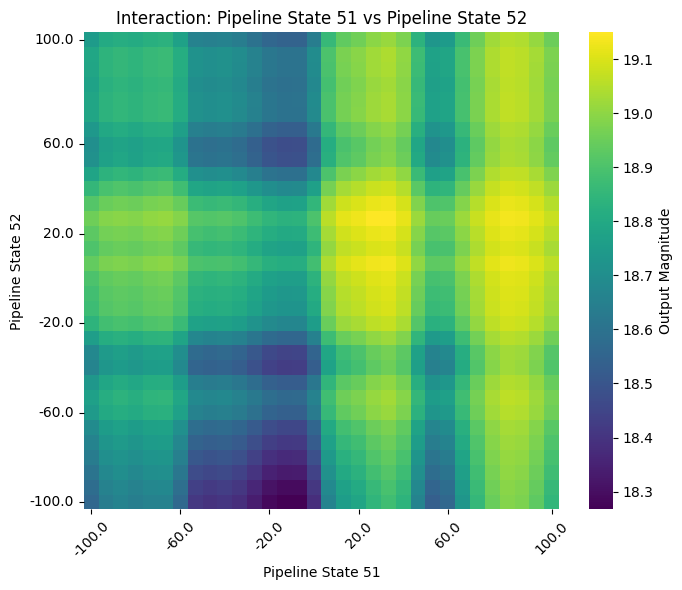

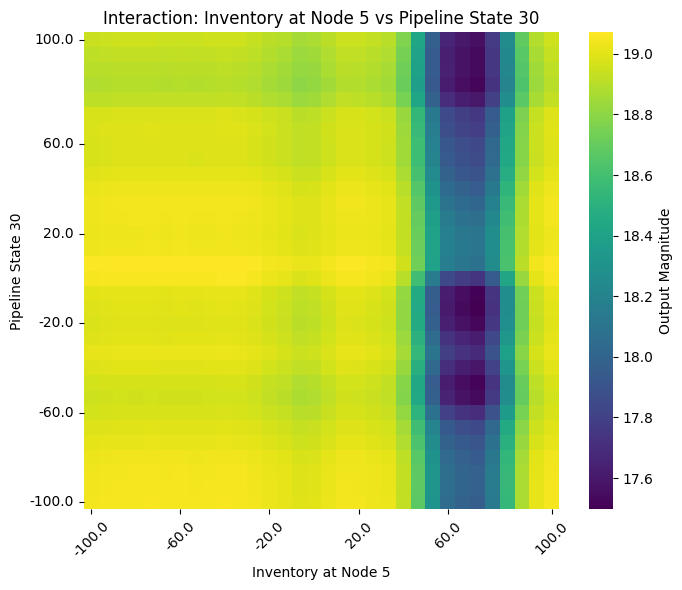

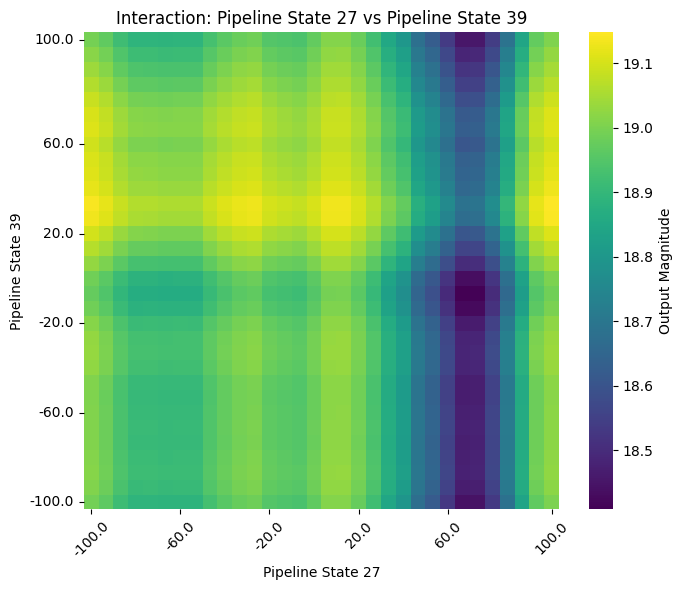

In [8]:
# ==============================================================================
# 5. DNAMite FEATURE CONTRIBUTION ANALYSIS (Adapted from NAM)
# ==============================================================================
import sys
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.utils.annotations import override
import or_gym
from or_gym.utils import create_env

# --- PATCH: Fix Numpy 1.24+ compatibility ---
if not hasattr(np, 'object'):
    np.object = object
if not hasattr(np, 'bool'):
    np.bool = bool
if not hasattr(np, 'int'):
    np.int = int
if not hasattr(np, 'typeDict'):
    np.typeDict = np.sctypeDict

# --- Ensure dnamite is importable ---
try:
    from dnamite.models.base_single_split import _BaseSingleSplitDNAMiteModel
except ImportError:
    print("Error: Could not import dnamite. Please ensure it is installed and in the python path.")
    class _BaseSingleSplitDNAMiteModel: pass

# --- Redefine Model Class ---
class LibraryDNAMite_RL(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        
        self.contribution_dim = 16 
        n_features = obs_space.shape[0]
        self.n_bins = 32  
        self.num_pairs = 10 
        
        low = -100.0
        high = 100.0
        if hasattr(obs_space, 'low') and hasattr(obs_space, 'high'):
            if np.all(np.isfinite(obs_space.low)) and np.all(np.isfinite(obs_space.high)):
                l = np.min(obs_space.low)
                h = np.max(obs_space.high)
                if l > -1e6 and h < 1e6:
                    low = float(l)
                    high = float(h)
        
        self.register_buffer('boundaries', torch.linspace(low, high, self.n_bins - 1))
        
        feature_sizes = [self.n_bins] * n_features
        all_pairs = list(itertools.combinations(range(n_features), 2))
        
        if self.num_pairs is None or self.num_pairs >= len(all_pairs):
            selected_pairs = all_pairs
        else:
            random.seed(42) 
            selected_pairs = random.sample(all_pairs, self.num_pairs)

        cat_feat_mask = torch.zeros(n_features, dtype=torch.bool)
        
        self.node_model = _BaseSingleSplitDNAMiteModel(
            n_features=n_features,
            n_output=self.contribution_dim,
            feature_sizes=feature_sizes,
            n_embed=16,
            n_hidden=16,
            n_layers=2,
            device='cpu',
            cat_feat_mask=cat_feat_mask,
            fit_pairs=True,           
            pairs_list=selected_pairs 
        )
        
        self.layer_norm = nn.LayerNorm(self.contribution_dim)
        self.actor_head = nn.Linear(self.contribution_dim, num_outputs)
        self.value_head = nn.Linear(self.contribution_dim, 1)
        self._last_total_contribution = None
        self._is_training = False

    def forward(self, input_dict, state, seq_lens):
        self._is_training = "is_training" not in input_dict or input_dict["is_training"]
        obs = input_dict["obs_flat"].float()
        obs_indices = torch.bucketize(obs, self.boundaries)
        obs_indices = torch.clamp(obs_indices, 0, self.n_bins - 1)
        total_contribution = self.node_model(mains=obs_indices)
        total_contribution = self.layer_norm(total_contribution)
        self._last_total_contribution = total_contribution
        logits = self.actor_head(total_contribution)
        return logits, state

    def value_function(self):
        assert self._last_total_contribution is not None
        value = self.value_head(self._last_total_contribution).squeeze(1)
        if not self._is_training:
            return value.cpu()
        return value

ModelCatalog.register_custom_model("library_dnamite", LibraryDNAMite_RL)

def get_flat_feature_names(env_instance):
    num_demands = len(env_instance.retail_links)
    num_inventories = len(env_instance.main_nodes)
    pipeline_length = getattr(env_instance, 'pipeline_length', 0)
    obs_dim = env_instance.observation_space.shape[0]
    expected_dim = num_demands + num_inventories + pipeline_length
    
    if obs_dim != expected_dim:
        return [f"Feature {i}" for i in range(obs_dim)]

    names = [f"Market Demand {i}" for i in range(num_demands)]
    names += [f"Inventory at Node {node}" for node in env_instance.main_nodes]
    names += [f"Pipeline State {i}" for i in range(pipeline_length)]
    return names

def plot_dnamite_interaction_2d(trainer, feature_names):
    """
    Generates 2D heatmaps for feature interactions.
    """
    try:
        policy = trainer.get_policy()
        model = policy.model
    except Exception as e:
        print(f"Error getting policy or model: {e}")
        return
    
    if not isinstance(model, LibraryDNAMite_RL):
        if not hasattr(model, 'node_model'):
            print(f"Model is not compatible. Type: {type(model)}")
            return

    device = next(model.parameters()).device
    print(f"\nModel is on device: {device}")
    
    # Reconstruct the pairs that were selected during training
    n_features = len(feature_names)
    all_pairs = list(itertools.combinations(range(n_features), 2))
    num_pairs = 10 # Hardcoded in class definition
    
    random.seed(42) # Must match the seed in LibraryDNAMite_RL
    if num_pairs >= len(all_pairs):
        selected_pairs = all_pairs
    else:
        selected_pairs = random.sample(all_pairs, num_pairs)
    
    print(f"Generating 2D Interaction Plots for {len(selected_pairs)} pairs...")
    
    n_bins = model.n_bins
    ref_bin = n_bins // 2
    
    # Get boundaries for axis labels
    if hasattr(model, 'boundaries'):
        boundaries = model.boundaries.cpu().numpy()
        # Create labels for ticks (e.g., 5 ticks)
        tick_indices = np.linspace(0, n_bins-1, 6, dtype=int)
        tick_labels = [f"{boundaries[i]:.1f}" if i < len(boundaries) else f"{boundaries[-1]:.1f}" for i in tick_indices]
    else:
        tick_indices = np.linspace(0, n_bins-1, 6, dtype=int)
        tick_labels = tick_indices

    # Plot all pairs
    pairs_to_plot = selected_pairs
    
    for (feat_i, feat_j) in pairs_to_plot:
        name_i = feature_names[feat_i]
        name_j = feature_names[feat_j]
        
        # Create grid
        grid_i = np.arange(n_bins)
        grid_j = np.arange(n_bins)
        mesh_i, mesh_j = np.meshgrid(grid_i, grid_j)
        
        flat_i = mesh_i.flatten()
        flat_j = mesh_j.flatten()
        batch_size = len(flat_i)
        
        # Prepare input: set pair to grid values, others to ref_bin
        input_indices = torch.full((batch_size, n_features), ref_bin, dtype=torch.long, device=device)
        input_indices[:, feat_i] = torch.tensor(flat_i, device=device)
        input_indices[:, feat_j] = torch.tensor(flat_j, device=device)
        
        with torch.no_grad():
            contributions = model.node_model(mains=input_indices)
            contributions = model.layer_norm(contributions)
            
        # Calculate magnitude
        y_vals = torch.norm(contributions, dim=1).cpu().numpy()
        y_grid = y_vals.reshape(n_bins, n_bins)
        
        # Plot
        plt.figure(figsize=(7, 6))
        # Use RdBu_r (Red-Blue reversed) or viridis. 
        # RdBu is good if values are centered around 0, but here we have L2 norm (always positive).
        # So viridis or plasma is better.
        sns.heatmap(y_grid, cmap="viridis", 
                    xticklabels=tick_indices, yticklabels=tick_indices,
                    cbar_kws={'label': 'Output Magnitude'})
        
        # Fix ticks to show actual values
        plt.xticks(tick_indices + 0.5, tick_labels, rotation=45)
        plt.yticks(tick_indices + 0.5, tick_labels, rotation=0)
        
        plt.title(f"Interaction: {name_i} vs {name_j}")
        plt.xlabel(name_i)
        plt.ylabel(name_j)
        plt.gca().invert_yaxis() # Put 0 at bottom-left
        plt.tight_layout()
        plt.show()

# --- Execution ---

print("\n--- Starting Feature Contribution Analysis ---")

if not ray.is_initialized():
    ray.init(ignore_reinit_error=True, num_gpus=0)

env_name = 'NetworkManagement-v0'
env_creator = create_env(env_name)
env_config = {}

rl_config = dict(
    env=env_name,
    num_workers=0,
    env_config=env_config,
    model=dict(
        custom_model="library_dnamite",
        custom_model_config={},
    ),
    clip_actions=True, 
    vf_clip_param=650000.0,
    lr=1.5e-5,
    entropy_coeff=0.01,
    num_sgd_iter=20,
    train_batch_size=4000,
    sgd_minibatch_size=128,
    horizon=200, 
    framework="torch",
    num_gpus=0,
)

try:
    temp_env = env_creator(env_name, env_config=env_config)
    feature_names = get_flat_feature_names(temp_env)
    print(f"Feature Names: {feature_names}")
except Exception as e:
    print(f"Error creating temp env: {e}")
    feature_names = []

checkpoint_path = r"C:\Users\24912/ray_results\PPO_NetworkManagement-v0_2025-11-21_02-17-19ne93n4qj\checkpoint_300\checkpoint-300"
checkpoint_path = os.path.normpath(checkpoint_path)

if os.path.exists(checkpoint_path):
    print(f"Restoring agent from {checkpoint_path}...")
    try:
        agent_analysis = PPOTrainer(env=env_name, config=rl_config)
        agent_analysis.restore(checkpoint_path)
        
        if feature_names:
            # Call the new 2D interaction plot function
            plot_dnamite_interaction_2d(agent_analysis, feature_names)
        else:
            print("Skipping plotting because feature names could not be determined.")
            
    except Exception as e:
        print(f"Error restoring agent or plotting: {e}")
else:
    print(f"Checkpoint path not found: {checkpoint_path}")

ray.shutdown()